# Assignment 9: Autoencoder


### Build an autoencoder for the Kaggle MNIST training dataset.

Import and preprocess data
Set parameters and define autoencoder backpropagation function
Run a process to train autoencoder
Visualise what the autoencoder has learned
Take the output of that autoencoder and use it to classify the MNIST test set observations.  Submit your results to Kaggle.com.

# Discussion 

Although not part of the prompt, I thought it necessary to add a few discussion points. It seems that both autoencoders (stacked autoencoders and convolutional autoencoders) perform quite well. The reconstructed images are quite legible and discernable. Both autoencoders are able to reconstruct digits from a given imput. However, the stacked autoencoder training is nearly an order of magnitude faster to train and performs better for the kaggle submissions. The model development was not exhaustive however, and improvements can likely be made by adjusting the size of the coding layer and the end of the encoder portion of the convolutional autoencoder. These adjustments given enough experimentation would likely lead to the convolutional autoencoder outpreforming the stacked autoencoder because of the use of filters and pooling layers. As it stands, quite a bit of 'smudginess' is present in the reconstructed example for the digit 4 provided in the summary table when using the convolutional autoencoder. The stacked autoencoder doesn't impart this smudge and retains a crisp reconstruction. Both encoders were able to achieve better performance than the simple artificial nueral network; as such employing an autoencoder as a method of preprocessing input images for and ANN apears to be a reasonable strategy in this case.

## Testing

In [1]:
# import base packages into the namespace for this program
import os
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime

#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from keras import layers

import pydot
import graphviz
import getpass
import smtplib

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.manifold import TSNE



In [2]:
# read data for the Boston Housing Study
Digit_input = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/Digits-Train.csv")
Digit_test = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/test.csv")
#sets random seed for entire notebook
RANDOM_SEED = 13


In [3]:
Digit_input.label.value_counts().sort_values()

5    3795
8    4063
4    4072
0    4132
6    4137
2    4177
9    4188
3    4351
7    4401
1    4684
Name: label, dtype: int64

## Build our tensorboard log function

In [4]:
logdir = 'C:/Users/bblank/Documents/keras_logfiles'
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join('C:/Users/bblank/Documents/keras_logfiles', run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## Split our data train and validation holdout

In [5]:
#splits into validation and train.
train, val =  train_test_split(Digit_input, test_size = 0.3, random_state = RANDOM_SEED)
val, test = train_test_split(val, test_size =0.3 , random_state =RANDOM_SEED)

y_train = train.label.copy()
X_train = train.drop('label', axis=1)

y_val = val.label.copy()
X_val = val.drop('label', axis=1)

y_test = test.label.copy()
X_test = test.drop('label', axis=1)

## Quick image EDA

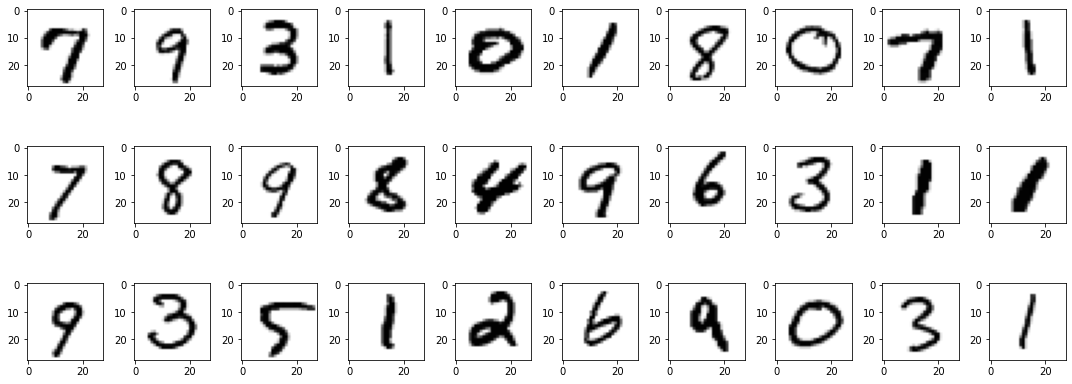

In [6]:
## plots the first 30 digits in 3 rows of 10 images. Data is unscaled
num_row = 3
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(30):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(X_train.iloc[i]).reshape(28,28), cmap='gist_yarg')
    #ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [7]:


X_train = X_train.astype('float32')/255.
X_val = X_val.astype('float32')/255.



In [8]:
scale = Pipeline([
        ('scaler', MinMaxScaler())
        ])

        
X_train = scale.fit_transform(X_train)
x_val = scale.fit_transform(X_val)
x_test = scale.fit_transform(X_test)

In [9]:
X_train = np.asarray(X_train)
X_val= np.asarray(X_val)
X_train = X_train.reshape((len(X_train), 28,28,1))
X_val = X_val.reshape((len(X_val), 28,28,1))

X_train.shape

(29400, 28, 28, 1)

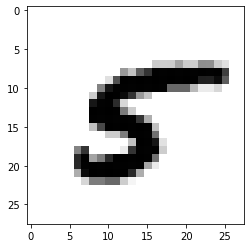

In [10]:
plt.imshow(X_val[1], cmap='gist_yarg')

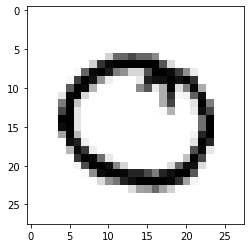

In [11]:
plt.imshow(X_train[7], cmap='gist_yarg')

In [12]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

optimizer = keras.optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [13]:
before_fit = datetime.now()
Convo_history= autoencoder.fit(X_train, X_train, epochs=10, batch_size=128, shuffle=True,
                validation_data=(X_val, X_val))


after_fit = datetime.now()


elapsed =after_fit - before_fit
convo_duration = elapsed.total_seconds()

Epoch 1/10
230/230 [==============================] - 26s 113ms/step - loss: 0.3667 - val_loss: 0.1774
Epoch 2/10
230/230 [==============================] - 25s 108ms/step - loss: 0.1688 - val_loss: 0.1497
Epoch 3/10
230/230 [==============================] - 25s 108ms/step - loss: 0.1455 - val_loss: 0.1369
Epoch 4/10
230/230 [==============================] - 28s 123ms/step - loss: 0.1341 - val_loss: 0.1284
Epoch 5/10
230/230 [==============================] - 28s 120ms/step - loss: 0.1267 - val_loss: 0.1229
Epoch 6/10
230/230 [==============================] - 26s 111ms/step - loss: 0.1211 - val_loss: 0.1183
Epoch 7/10
230/230 [==============================] - 27s 117ms/step - loss: 0.1176 - val_loss: 0.1157
Epoch 8/10
230/230 [==============================] - 25s 111ms/step - loss: 0.1145 - val_loss: 0.1133
Epoch 9/10
230/230 [==============================] - 26s 111ms/step - loss: 0.1126 - val_loss: 0.1118
Epoch 10/10
230/230 [==============================] - 28s 120ms/step - l

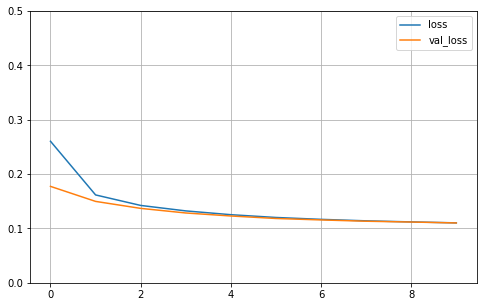

In [14]:
pd.DataFrame(Convo_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.5)
plt.show()

In [15]:
X_test = X_test.astype('float32')/255.
X_test= np.asarray(X_test)
X_test = X_test.reshape((len(X_test), 28,28,1))

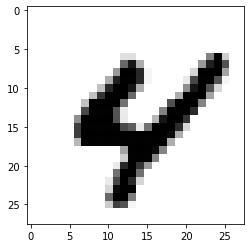

In [16]:
plt.imshow(X_test[12], cmap='gist_yarg')

In [17]:
preds = autoencoder.predict(X_test)


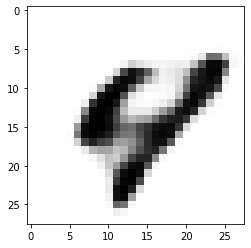

In [18]:
plt.imshow(preds[12], cmap='gist_yarg')

In [19]:

X_train = X_train.reshape((len(X_train), 28,28))
X_val = X_val.reshape((len(X_val), 28,28))
X_test = np.asarray(X_test)
X_test = X_test.reshape((len(X_test), 28,28))

In [20]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation= 'selu')
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape=([30])),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

stacked_auto = keras.models.Sequential([stacked_encoder,stacked_decoder])
stacked_auto.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5))

In [21]:
before_fit = datetime.now()
stacked_history= stacked_auto.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))
after_fit = datetime.now()


elapsed =after_fit - before_fit
stacked_duration = elapsed.total_seconds()

Epoch 1/10
919/919 [==============================] - 3s 3ms/step - loss: 0.2643 - val_loss: 0.1608
Epoch 2/10
919/919 [==============================] - 2s 3ms/step - loss: 0.1531 - val_loss: 0.1368
Epoch 3/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1335 - val_loss: 0.1266
Epoch 4/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1242 - val_loss: 0.1204
Epoch 5/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1194 - val_loss: 0.1175
Epoch 6/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1164 - val_loss: 0.1142
Epoch 7/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1140 - val_loss: 0.1141
Epoch 8/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1123 - val_loss: 0.1119
Epoch 9/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1107 - val_loss: 0.1112
Epoch 10/10
919/919 [==============================] - 2s 2ms/step - loss: 0.1100 - val_loss: 0.1101

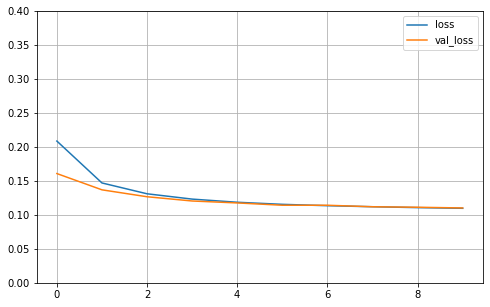

In [22]:
pd.DataFrame(stacked_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.4)
plt.show()

In [23]:
stacked_preds = stacked_auto.predict(X_test)


In [24]:
stacked_preds.shape

(3780, 28, 28)

## Representations of digits in a lower dimensional space

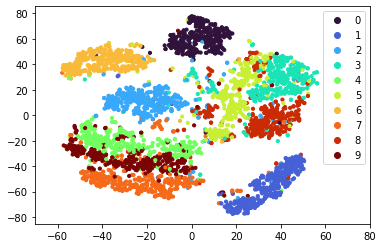

In [25]:
tsne = TSNE()
#use encoder to reduce dimensionality for TNSE
encoder_preds = stacked_encoder.predict(X_test)
X_test_2D = tsne.fit_transform(encoder_preds)

#generate legend labels
labels = np.unique(y_test).tolist()

#render the clusters of data in a 2 dimensional space
fig, ax = plt.subplots()

scatter = ax.scatter(X_test_2D[:, 0], X_test_2D[:,1], c=y_test, label=labels, s=10, cmap='turbo')
ax.set_xlim([-70, 80])
ax.legend(handles=scatter.legend_elements()[0], labels=labels)

# MNIST image autoencoder results

## Original image

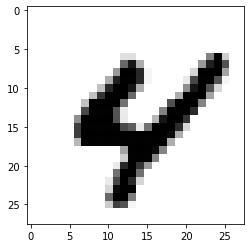

In [29]:
plt.imshow(X_test[12], cmap='gist_yarg')
plt.savefig('original.png', transparent=True)

## Convolutional Autoencoder Results

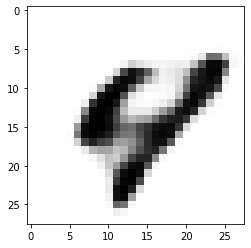

In [30]:
plt.imshow(preds[12], cmap='gist_yarg')
plt.savefig('Convolutional.png', transparent=True)

## Stacked Autoencoder Results

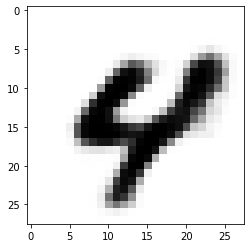

In [31]:
plt.imshow(stacked_preds[12], cmap='gist_yarg')
plt.savefig('Stacked.png', transparent=True)

# Making predictions with decoded images

In [32]:
#prepare the kaggle test digits
X_kaggle = Digit_test.astype('float32')/255.
X_kaggle = scale.fit_transform(X_kaggle)
X_kaggle = X_kaggle.reshape((len(X_kaggle), 28,28,1))

In [33]:
sAE_Kaggle_preds = stacked_auto.predict(X_kaggle)
cAE_Kaggle_preds = autoencoder.predict(X_kaggle)


In [34]:
cAE_Kaggle_preds.shape

(28000, 28, 28, 1)

In [35]:
sAE_Kaggle_preds.shape

(28000, 28, 28)

In [36]:
X_train.shape

(29400, 28, 28)

In [37]:
#generates new training val and test sets with our stacked autoencoder
sAE_X_train= stacked_auto.predict(X_train)
sAE_X_val = stacked_auto.predict(X_val)
sAE_X_test = stacked_auto.predict(X_test)

#generates new training, val, and test sets with our convolutional autoencoder
cAE_X_train= autoencoder.predict(X_train)
cAE_X_val = autoencoder.predict(X_val)
cAE_X_test = autoencoder.predict(X_test)

In [38]:
sAE_X_train.shape

(29400, 28, 28)

In [39]:
cAE_X_train.shape

(29400, 28, 28, 1)

In [40]:
### previously model from ANN attempts
opt = keras.optimizers.SGD(learning_rate=0.01)

model_5L40N= keras.models.Sequential()
model_5L40N.add(keras.layers.Flatten(input_shape=[28,28]))
model_5L40N.add(keras.layers.Dense(40, activation ='relu'))
model_5L40N.add(keras.layers.Dense(40, activation ='relu'))
model_5L40N.add(keras.layers.Dense(40, activation ='relu'))
model_5L40N.add(keras.layers.Dense(40, activation ='relu'))
model_5L40N.add(keras.layers.Dense(40, activation ='relu'))
model_5L40N.add(keras.layers.Dense(10, activation ='softmax'))
model_5L40N.summary()
model_5L40N.compile(loss= "sparse_categorical_crossentropy", optimizer = opt,
    metrics = ['accuracy'])
#train our ANN on the decoded training images for stacked autoencoder (sAE) convolutional autoencoder (cAE)

before_fit= datetime.now()
train_sAE_5L40N = model_5L40N.fit(sAE_X_train, y_train, epochs=30, validation_data = (sAE_X_val, y_val))
after_fit = datetime.now()
elapsed =after_fit - before_fit
sAE_duration = elapsed.total_seconds()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 40)                31400     
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_6 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_7 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_8 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

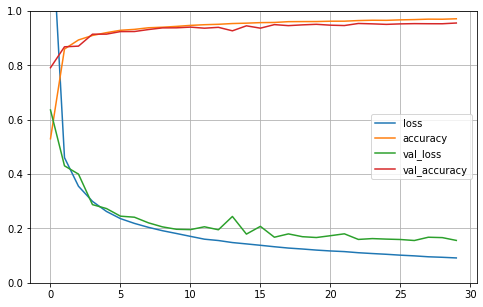

In [41]:
pd.DataFrame(train_sAE_5L40N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [42]:


sAE_preds = model_5L40N.predict_classes(sAE_Kaggle_preds)
ImageId = np.linspace(1,len(sAE_preds),len(sAE_preds))
labels = pd.DataFrame({"ImageId": ImageId, "Label": sAE_preds})
#labels.to_csv('submission_sAE.csv' ,index=False)



C:\Users\bblank\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [43]:
before_fit = datetime.now()
train_cAE_5L40N = model_5L40N.fit(cAE_X_train, y_train, epochs=30, validation_data = (cAE_X_val, y_val))
after_fit = datetime.now()
elapsed =after_fit - before_fit
cAE_duration = elapsed.total_seconds()

Epoch 1/30
919/919 [==============================] - 2s 2ms/step - loss: 0.2898 - accuracy: 0.9078 - val_loss: 0.2854 - val_accuracy: 0.9117
Epoch 2/30
919/919 [==============================] - 1s 2ms/step - loss: 0.2360 - accuracy: 0.9228 - val_loss: 0.2662 - val_accuracy: 0.9159
Epoch 3/30
919/919 [==============================] - 1s 2ms/step - loss: 0.2134 - accuracy: 0.9315 - val_loss: 0.2704 - val_accuracy: 0.9150
Epoch 4/30
919/919 [==============================] - 1s 2ms/step - loss: 0.2001 - accuracy: 0.9343 - val_loss: 0.2554 - val_accuracy: 0.9186
Epoch 5/30
919/919 [==============================] - 1s 2ms/step - loss: 0.1897 - accuracy: 0.9371 - val_loss: 0.2381 - val_accuracy: 0.9262
Epoch 6/30
919/919 [==============================] - 1s 2ms/step - loss: 0.1821 - accuracy: 0.9409 - val_loss: 0.2290 - val_accuracy: 0.9283
Epoch 7/30
919/919 [==============================] - 1s 2ms/step - loss: 0.1733 - accuracy: 0.9433 - val_loss: 0.2303 - val_accuracy: 0.9281
Epoch 

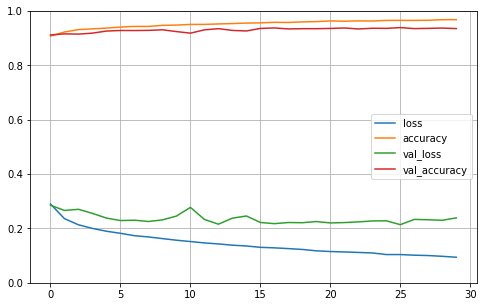

In [44]:
pd.DataFrame(train_cAE_5L40N.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [45]:
cAE_preds = model_5L40N.predict_classes(cAE_Kaggle_preds)
ImageId = np.linspace(1,len(cAE_preds),len(cAE_preds))
labels = pd.DataFrame({"ImageId": ImageId, "Label": cAE_preds})
#labels.to_csv('submission_cAE.csv' ,index=False)



C:\Users\bblank\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# Summary

In [54]:
Summary = {
    'Methodology': ['original','StackedAutoencoder', 'ConvolutionalAutoencoder'], 
    'TrainingDuration (s)': [0, round(stacked_duration, 2), round(convo_duration, 2)],
    'DecodedImageTrainDuration (s)': [0, round(sAE_duration, 2), round(cAE_duration, 2)],
    'KaggleScore': [0, 95.1 , 93.9 ]
        }

df = pd.DataFrame.from_dict(Summary)

In [50]:
images = ['original.png', 'Stacked.png', 'Convolutional.png']

In [55]:
from IPython.display import Image, HTML
df['image'] = images

# convert your links to html tags 
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

pd.set_option('display.max_colwidth', None)

display(HTML(df.to_html(escape=False ,formatters=dict(image=path_to_image_html))))

,Methodology,TrainingDuration (s),DecodedImageTrainDuration (s),KaggleScore,image
0,original,0.00,0.00,0.0,
1,StackedAutoencoder,20.49,32.35,95.1,
2,ConvolutionalAutoencoder,263.32,44.41,93.9,
